In [23]:
# Importing the libraries and functions from model.py file
from model import *

In [24]:
# load water molecules and frames from xtc file and gro file
all_frames = md.load_xtc("../10_7/singlesim/it50k/eql2.xtc",top="../10_7/singlesim/it50k/conf.gro")


In [25]:
# Extracting the first frame from the xtc file
molecule = all_frames[0]
atomic_nums = [atom.element.atomic_number for atom in molecule.top.atoms] 
water = Atoms(positions= molecule.xyz[0], numbers=atomic_nums)

In [26]:
# Calculating the feature matrix for each frame in the xtc file
frames = all_frames
features = []
for molecule in tqdm(frames):
    atomic_nums = np.array([[atom.element.atomic_number for atom in molecule.top.atoms]]).T
    vdwr = np.array([[atom.element.radius for atom in molecule.top.atoms]]).T
    mass = np.array([[atom.element.mass for atom in molecule.top.atoms]]).T
    positions = molecule.xyz[0]*10
    
    # positions = positions - positions[0]
    
    node_features = np.concatenate((positions,vdwr,atomic_nums),axis=1)
    features.append(node_features)
    
features = np.array(features)

100%|██████████| 50001/50001 [00:02<00:00, 22497.72it/s]


In [27]:
# Printing node features for testing purposes
print("Node Features:\n",features[10])

Node Features:
 [[13.46083832 12.57285213 13.48372459  0.152       8.        ]
 [13.04025745 13.2220211  14.04757309  0.12        1.        ]
 [12.84028053 12.43922329 12.76728725  0.12        1.        ]
 [13.34977245 12.62784863 13.46744633  0.          0.        ]]


In [46]:
for ine in all_frames[0]:
    print(ine)

<mdtraj.Trajectory with 1 frames, 4 atoms, 1 residues, and unitcells>


In [47]:
# creating edge list for the graph nodes
from_list = []
to_list = []
for edge in all_frames.topology.bonds:
    from_list.append(edge.atom1.index)
    to_list.append(edge.atom2.index)
    from_list.append(edge.atom2.index)
    to_list.append(edge.atom1.index)

edge_list = np.array([from_list,to_list])

In [48]:
edge_list

array([[0, 1, 0, 2],
       [1, 0, 2, 0]])

In [29]:
# appending graphs to a list
graphs=[]
for node_feature in tqdm(features):
    graph = data.Data(x=torch.from_numpy(node_feature),edge_index=torch.from_numpy(edge_list))
    graphs.append(graph)
    

100%|██████████| 50001/50001 [00:01<00:00, 41314.14it/s]


In [30]:
print(graphs[0]) 
# features per node positions and vanderwaals radius and atomic number
# edge index is the edge list of the graph

Data(x=[4, 5], edge_index=[2, 4])


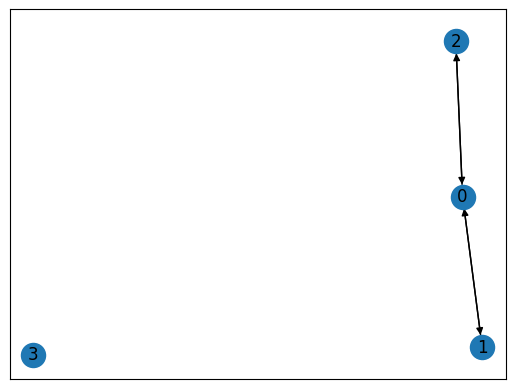

In [31]:
# Visualizing the graph network
vis = to_networkx(graphs[0])
nx.draw_networkx(vis, with_labels=True)


In [32]:
# using cuda if available
# and moving the graphs to the device
# using whichever is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
graphs_device = []
for graph in tqdm(graphs):
    graphs_device.append(graph.to(device))

100%|██████████| 50001/50001 [00:00<00:00, 113297.10it/s]


In [33]:
import os
in_channels = graph.num_features
out_channels = 3
n_atoms = 4
lr = 1e-3
n_epochs = 100
batch_size=256
test_train_split = 0.8
model_name = "Intra.pt"
model_loaded = False
force_train = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if os.path.exists("./models/"+model_name) and not force_train:
    model = torch.load("./models/"+model_name)
    model_loaded = True
else:
    model = VGAE(VariationalGCNEncoder(in_channels, out_channels,batch_size,n_atoms),
                VariationalGCNDecoder(out_channels, in_channels,batch_size,n_atoms))
    
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

In [34]:
split = int(test_train_split * len(graphs_device))
train_loader = DataLoader(graphs_device[:split], batch_size=batch_size,shuffle=True)
test_loader = DataLoader(graphs_device[split:], batch_size=batch_size,shuffle=True)

In [35]:
print("Using:",device )
print("total_graphs:", len(graphs_device))
print("Graphs in a batch:", batch_size)
print("Train Graphs Batches:",len(train_loader),f"(Total graphs: {len(train_loader)*batch_size})")
print("Test Graphs Batches:",len(test_loader),f"(Total graphs: {len(test_loader)*batch_size})")
print("Model Specifics:\n",model)

Using: cpu
total_graphs: 50001
Graphs in a batch: 256
Train Graphs Batches: 157 (Total graphs: 40192)
Test Graphs Batches: 40 (Total graphs: 10240)
Model Specifics:
 VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GATConv(5, 15, heads=3)
    (head_transform1): Linear(45, 15, bias=True)
    (bn1): BatchNorm(15)
    (conv2): GCNConv(15, 9)
    (bn2): BatchNorm(9)
    (linear1): Linear(9, 100, bias=True)
    (linear2): Linear(100, 4, bias=True)
    (transform): Linear(16, 3, bias=True)
    (mu): Linear(3, 3, bias=True)
    (logstd): Linear(3, 3, bias=True)
  )
  (decoder): VariationalGCNDecoder(
    (inv_transform): Linear(3, 4, bias=True)
    (conv1): GCNConv(1, 9)
    (bn1): BatchNorm(9)
    (conv2): GCNConv(9, 3)
    (bn2): BatchNorm(3)
    (conv3): GCNConv(3, 3)
    (linear1): Linear(3, 512, bias=True)
    (linear2): Linear(512, 128, bias=True)
    (linear3): Linear(128, 5, bias=True)
  )
)


In [36]:
lossFxn = torch.nn.MSELoss()
def train():
    model.train()
    model.double()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    position_loss_all = 0

    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        
        heavy_indices = torch.where(data.x[:,4] > torch.tensor([1]).to(device))
     
        
        decoded_pos = decoded_x[:,:3]
        decoded_features = decoded_x[:,3:]
        orignal_pos = data.x[:,:3]
        orignal_features = data.x[:,3:]


        positionLoss = lossFxn(decoded_pos[heavy_indices], orignal_pos[heavy_indices])
        FeatureLoss = lossFxn(decoded_features[heavy_indices], orignal_features[heavy_indices])
        loss = lossFxn(decoded_x[heavy_indices], data.x[heavy_indices])
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)


        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        position_loss_all += float(positionLoss)

#         positionLoss.backward()
        loss.backward()
        optimizer.step()

    return loss_all / len(train_loader), feature_loss_all / len(train_loader), edge_loss_all / len(train_loader) ,position_loss_all / len(train_loader)

In [37]:
lossFxn = torch.nn.MSELoss()
def test():
    model.eval()
    model.double()
    
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    position_loss_all = 0

    for data in test_loader:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)

        decoded_pos = decoded_x[:,:3]
        decoded_features = decoded_x[:,3:]
        orignal_pos = data.x[:,:3]
        orignal_features = data.x[:,3:]
        
        
        heavy_indices = torch.where(data.x[:,4] > torch.tensor([1]).to(device))
   
        
        positionLoss = lossFxn(decoded_pos[heavy_indices], orignal_pos[heavy_indices])
        FeatureLoss = lossFxn(decoded_features[heavy_indices], orignal_features[heavy_indices])
        loss = lossFxn(decoded_x[heavy_indices], data.x[heavy_indices])

        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        
        
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        position_loss_all += float(positionLoss)



    return loss_all / len(test_loader), feature_loss_all / len(test_loader), edge_loss_all / len(test_loader), position_loss_all / len(test_loader)

In [38]:
train_total_losses = []
train_feature_losses = []
train_edge_losses = []
train_position_losses = []

test_total_losses = []
test_feature_losses = []
test_edge_losses = []
test_position_losses = []

early_stopper = EarlyStopper(patience=3, min_delta=10)


if model_loaded:        
    print("Pretrained Model Loaded, no training required")
else:
    for epoch in range(1, n_epochs + 1):
        train_total_loss, train_feature_loss, train_edge_loss,train_position_loss = train()
        test_total_loss, test_feature_loss, test_edge_loss,test_position_loss = test()
        
        print(f"Epoch: {epoch:03d}")
        print(f'\tTrain:\tTotal Loss: {train_total_loss:.4f}, Feature Loss: {train_feature_loss:.4f}, Position Loss: {train_position_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        print(f'\tTest: \tTotal Loss: {test_total_loss:.4f}, Feature Loss: {test_feature_loss:.4f}, Position Loss: {test_position_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
        
        if(early_stopper.early_stop(test_total_loss)):
            print("Early Stopping")
            break

        train_total_losses.append(train_total_loss)
        train_feature_losses.append(train_feature_loss)
        train_edge_losses.append(train_edge_loss)
        train_position_losses.append(train_position_loss)

        test_total_losses.append(test_total_loss)
        test_feature_losses.append(test_feature_loss)
        test_edge_losses.append(test_edge_loss)
        test_position_losses.append(test_position_loss)
        
        scheduler.step()

    torch.save(model,"./models/"+model_name)

Epoch: 001
	Train:	Total Loss: 11.0655, Feature Loss: 2.9470, Position Loss: 16.4778, LR: 0.001000
	Test: 	Total Loss: 1.4023, Feature Loss: 0.0135, Position Loss: 2.3282, LR: 0.001000
Epoch: 002
	Train:	Total Loss: 0.9805, Feature Loss: 0.0283, Position Loss: 1.6153, LR: 0.001000
	Test: 	Total Loss: 0.0293, Feature Loss: 0.0146, Position Loss: 0.0391, LR: 0.001000
Epoch: 003
	Train:	Total Loss: 0.0633, Feature Loss: 0.0044, Position Loss: 0.1026, LR: 0.001000
	Test: 	Total Loss: 0.1700, Feature Loss: 0.0008, Position Loss: 0.2828, LR: 0.001000
Epoch: 004
	Train:	Total Loss: 0.0374, Feature Loss: 0.0008, Position Loss: 0.0618, LR: 0.001000
	Test: 	Total Loss: 0.1103, Feature Loss: 0.0003, Position Loss: 0.1836, LR: 0.001000
Epoch: 005
	Train:	Total Loss: 0.0257, Feature Loss: 0.0004, Position Loss: 0.0426, LR: 0.001000
	Test: 	Total Loss: 0.0469, Feature Loss: 0.0002, Position Loss: 0.0780, LR: 0.001000
Epoch: 006
	Train:	Total Loss: 0.0261, Feature Loss: 0.0002, Position Loss: 0.0433,

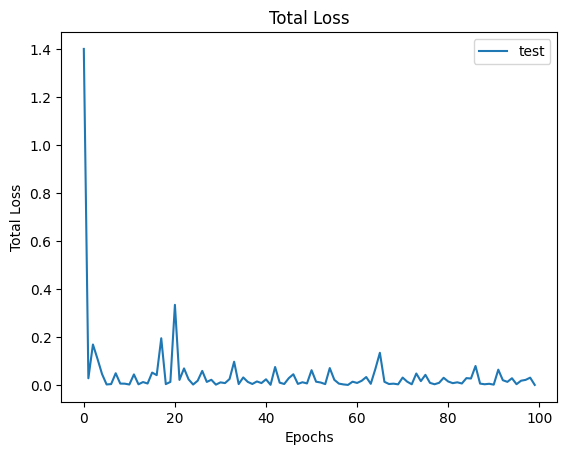

In [39]:
plt.plot(test_total_losses,label="test")
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.legend()
plt.title("Total Loss")
plt.savefig("./plots/"+model_name+"_total_loss.png")
plt.show()


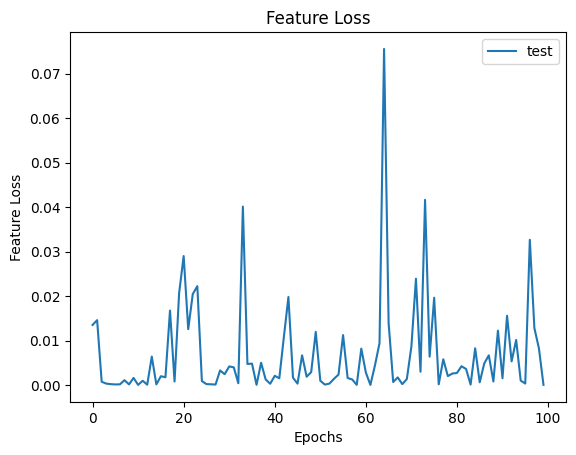

In [40]:
# train vs test feature loss

plt.plot(test_feature_losses,label="test")
plt.xlabel("Epochs")
plt.ylabel("Feature Loss")
plt.legend()
plt.title("Feature Loss")
plt.savefig("./plots/"+model_name+"_feature_loss.png")
plt.show()


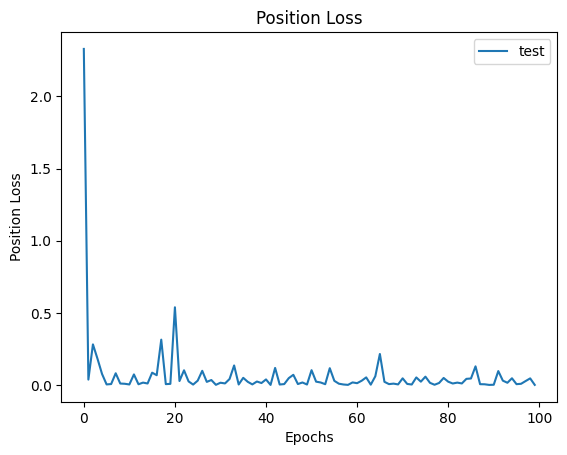

In [41]:
# train vs test position loss
# plt.plot(train_position_losses,label="train")
plt.plot(test_position_losses,label="test")
plt.xlabel("Epochs")
plt.ylabel("Position Loss")
plt.legend()
plt.title("Position Loss")
plt.savefig("./plots/"+model_name+"_position_loss.png")
plt.show()


In [42]:
from torch.functional import F

avg1 = 0
avg2 = 0

embeddings = []
input_feature = []
decoded_feature = []

for ind in range(len(test_loader)):
    test_graph = test_loader.dataset[ind]

    model.double()
    z,encoded_edge_index = model.encode(test_graph.x,test_graph.edge_index)
    decoded_x,decoded_edge_index = model.decode(z,encoded_edge_index)
    heavy_indices = torch.where(test_graph.x[:,4] > torch.tensor([1]).to(device))

    embeddings.append(z)
    decoded_feature.append(decoded_x)
    input_feature.append(test_graph.x)
    
    Error_wo_s = F.mse_loss(decoded_x[heavy_indices], test_graph.x[heavy_indices]).detach().cpu().numpy()
    # heavy indices here are the indices of the heavy atoms in the graph that is the atoms that are not hydrogen
    # write a function to calculate the error including the hydrogen atoms
    Error_w_s = F.mse_loss(decoded_x, test_graph.x).detach().cpu().numpy()


    avg1 += Error_wo_s
    avg2 += Error_w_s

print("Average Error without hydrogen - ", avg1/len(test_loader))
print("Average Error with hydrogen - ", avg2/len(test_loader))



Average Error without hydrogen -  0.0006241217660418004
Average Error with hydrogen -  8.225388893251303


In [43]:
np.set_printoptions(suppress=True)
heavy_indices = torch.where(input_feature[0][:,4] > torch.tensor([1]).to(device))
heavy_indices
print(decoded_feature[0][heavy_indices],input_feature[0][heavy_indices])
# tried to print the decoded feature and the input feature for the first graph in the test loader
# only the heavy atoms are printed
# now we need to print the hydrogen atoms as well
# we have the indices of the hydrogen atoms in the heavy indices variable

decoded_feature[0],input_feature[0]

tensor([[10.8004,  9.9265, 10.7918,  0.1505,  8.0105]], dtype=torch.float64,
       grad_fn=<IndexBackward0>) tensor([[10.7963,  9.9279, 10.7336,  0.1520,  8.0000]], dtype=torch.float64)


(tensor([[10.8004,  9.9265, 10.7918,  0.1505,  8.0105],
         [10.7760,  9.9038, 10.7674,  0.1503,  8.0106],
         [10.7484,  9.8787, 10.7399,  0.1502,  8.0101],
         [11.1163, 10.2148, 11.1069,  0.1502,  8.0111]], dtype=torch.float64,
        grad_fn=<LeakyReluBackward0>),
 tensor([[10.7963,  9.9279, 10.7336,  0.1520,  8.0000],
         [10.5830,  9.0389, 10.4501,  0.1200,  1.0000],
         [10.1523, 10.1238, 11.4141,  0.1200,  1.0000],
         [10.7049,  9.8540, 10.7760,  0.0000,  0.0000]], dtype=torch.float64))

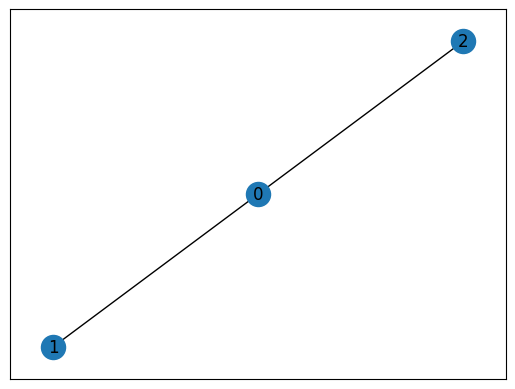

In [44]:
add_self_loops=False
adj_binary = convert_to_adj(decoded_edge_index, num_nodes=decoded_x.shape[0])
indices = torch.where(adj_binary)
G = nx.Graph()
if not add_self_loops:
    edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
    G.add_edges_from(edges)
else:
    G.add_edges_from(zip(indices[0].tolist(), indices[1].tolist()))
nx.draw_networkx(G)
plt.show()
